In [ ]:
#This is taken from https://github.com/ganguli-lab/pathint

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Parameters

In [2]:
select = tf.select if hasattr(tf, 'select') else tf.where

In [3]:
# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 256
activation_fn = tf.nn.relu

# Optimization params
batch_size = 64
epochs_per_task = 10

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

## Construct datasets

In [4]:
#task_labels = [[0,1], [2,3]]#, [4,5], [6,7], [8,9]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9], [4,6],[8,1],[0,3],[2,4],[5,7]]
# task_labels = [[0,1,2,3,4], [5,6,7,8,9]]
n_tasks = len(task_labels)
training_datasets = utils.construct_split_mnist(task_labels, split='train')
validation_datasets = utils.construct_split_mnist(task_labels, split='test')
# training_datasets = utils.mk_training_validation_splits(full_datasets, split_fractions=(0.9, 0.1))

## Construct network, loss, and updates

In [5]:
tf.reset_default_graph()

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [7]:
# tf.equal(output_mask[None, :], 1.0)

In [8]:
import keras.backend as K
import keras.activations as activations

output_mask = tf.Variable(tf.zeros(output_dim), name="mask", trainable=False)

def masked_softmax(logits):
    # logits are [batch_size, output_dim]
    x = select(tf.tile(tf.equal(output_mask[None, :], 1.0), [tf.shape(logits)[0], 1]), logits, -1e32 * tf.ones_like(logits))
    return activations.softmax(x)

def set_active_outputs(labels):
    new_mask = np.zeros(output_dim)
    for l in labels:
        new_mask[l] = 1.0
    sess.run(output_mask.assign(new_mask))
    #print(sess.run(output_mask))
    
def masked_predict(model, data, targets):
    pred = model.predict(data)
    #print(pred)
    acc = np.argmax(pred,1)==np.argmax(targets,1)
    return acc.mean()

In [9]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(n_hidden_units, activation=activation_fn, input_shape=(input_dim,)))
model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, kernel_initializer='zero', activation=masked_softmax))

In [10]:
from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import Adam, RMSprop,SGD
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory
from keras.callbacks import History 
from keras.callbacks import LambdaCallback

#protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum',xi=1e-3)
# protocol_name, protocol = protocols.SUM_FISHER_PROTOCOL('sum')
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
# opt = SGD(1e-3)
# opt = RMSprop(lr=1e-3)
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss='categorical_crossentropy', optimizer=oopt, metrics=['accuracy'])
model.model._make_train_function()
saved_weights = model.get_weights()

save_weights_epoch=[]
save_loss_epoch=[]
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: save_weights_epoch.append(model.get_weights()))
history = LossHistory()
#history = History()
callbacks = [history]
datafile_name = "split_mnist_data_%s.pkl.gz"%protocol_name

In [11]:
print(protocol)

{'regularizer_fn': <function quadratic_regularizer at 0x7fa60ad25378>, 'step_updates': [('grads2', <function <lambda>.<locals>.<lambda> at 0x7fa60ad25840>)], 'init_updates': [('cweights', <function <lambda>.<locals>.<lambda> at 0x7fa60ad01f28>)], 'task_updates': [('omega', <function <lambda>.<locals>.<lambda> at 0x7fa608436268>), ('cweights', <function <lambda>.<locals>.<lambda> at 0x7fa6084362f0>), ('grads2', <function <lambda>.<locals>.<lambda> at 0x7fa608436378>)]}


## Train!

In [12]:
def model_prune(task_number, unimportant_threshold):
    All_weights = model.get_weights()
    imp_par = {}
    
    lossdiff = save_loss_epoch[task_number][-2]-save_loss_epoch[task_number][-1]
    
    w1_old=save_weights_epoch[10*(task_number-1)+9][0]
    w1_new=save_weights_epoch[10*task_number+9][0]
    b1_old=save_weights_epoch[10*(task_number-1)+9][1]
    b1_new=save_weights_epoch[10*task_number+9][1]
    w2_old=save_weights_epoch[10*(task_number-1)+9][2]
    w2_new=save_weights_epoch[10*task_number+9][2]
    b2_old=save_weights_epoch[10*(task_number-1)+9][3]
    b2_new=save_weights_epoch[10*task_number+9][3]

    dw1 = np.true_divide(lossdiff,(np.array(w1_old) - np.array(w1_new))**2 + 1e-6)
    db1 = np.true_divide(lossdiff,(np.array(b1_old) - np.array(b1_new))**2 + 1e-6)
    dw2 = np.true_divide(lossdiff,(np.array(w2_old) - np.array(w2_new))**2 + 1e-6)
    db2 = np.true_divide(lossdiff,(np.array(b2_old) - np.array(b2_new))**2 + 1e-6)
    unimportant_threshold = np.mean(dw1)-1*np.std(dw1)
    unimportant_nodes_dw1 = np.where(dw1 < unimportant_threshold)
    unimportant_threshold = np.mean(db1)-1*np.std(db1)
    unimportant_nodes_db1 = np.where(db1 < unimportant_threshold)
    unimportant_threshold = np.mean(dw2)-1*np.std(dw2)
    unimportant_nodes_dw2 = np.where(dw2 < unimportant_threshold)
    unimportant_threshold = np.mean(db2)-1*np.std(db2)
    unimportant_nodes_db2 = np.where(db2 < unimportant_threshold)
    cusion_fraction = 0.8
    #if len(unimportant_nodes_dw1[0]) > cusion_fraction*len(unimportant_nodes_dw2[0]) and len(unimportant_nodes_dw1[0]) < cusion_fraction*(len(dw1)**2) and len(unimportant_nodes_dw2[0]) < cusion_fraction*(len(dw2)**2): 

    print('# of unimportant weights {0} in 1st layer out of {1} weights'.format(len(unimportant_nodes_dw1[0]),len(dw1)*len(dw1)))
    print('# of unimportant biases {0} in 1st layer out of {1} biases'.format(len(unimportant_nodes_db1[0]),len(db1)))
    print('# of unimportant weights {0} in 2nd layer out of {1} weights'.format(len(unimportant_nodes_dw2[0]),len(dw2)*len(dw2)))
    print('# of unimportant biases {0} in 2nd layer out of {1} biases'.format(len(unimportant_nodes_db2[0]),len(db2)))

    for i,j in zip(unimportant_nodes_dw1[0],unimportant_nodes_dw1[1]):
        All_weights[0][i][j] = 0

    for i in zip(unimportant_nodes_db1[0]):
        All_weights[1][i] = 0

    for i,j in zip(unimportant_nodes_dw2[0],unimportant_nodes_dw2[1]):
        All_weights[2][i][j] = 0

    for i in zip(unimportant_nodes_db2[0]):
        All_weights[3][i] = 0

    model.set_weights(All_weights)
    imp_par['iw1'] = dw1; imp_par['ib1'] = db1; imp_par['iw2'] = dw2; imp_par['ib2'] = db2
    return imp_par

In [13]:
def run_fits(cvals, training_data, valid_data, eval_on_train_set=False, nstats=1):
    acc_mean = dict()
    acc_std = dict()
    model_weights_save = []   #Empty list to save the model weights aftertraining each task
    imp_par = dict()  #Empty list to save importance parameter after learning each progressive task
    for cidx, cval_ in enumerate(tqdm(cvals)):
        runs = []
        for runid in range(nstats):
            sess.run(tf.global_variables_initializer())
            # model.set_weights(saved_weights)
            cstuffs = []
            evals = []
            print("setting cval")
            cval = cval_
            oopt.set_strength(cval)
            oopt.init_task_vars()
            print("cval is", sess.run(oopt.lam))
            for age, tidx in enumerate(range(n_tasks)):
                print("Age %i, cval is=%f"%(age,cval))
                print("settint output mask")
                set_active_outputs(task_labels[age])
                stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=[print_weights])
                save_loss_epoch.append(stuffs.history['loss'])
                if age != 0:
                    imp_par[age] = model_prune(age, unimportant_threshold = n_tasks-age)
                oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
                oopt.update_task_vars()
                ftask = []
                model_weights_save.append(model.get_weights()) #Save the model weights aftertraining each task
                for j in range(n_tasks):
                    set_active_outputs(task_labels[j])
                    if eval_on_train_set:
                        f_ = masked_predict(model, training_data[j][0], training_data[j][1])
                    else:
                        f_ = masked_predict(model, valid_data[j][0], valid_data[j][1])
                    ftask.append(np.mean(f_))
                evals.append(ftask)
                cstuffs.append(stuffs)

                # Re-initialize optimizater variables
                if reset_optimizer:
                    oopt.reset_optimizer()

            evals = np.array(evals)
            runs.append(evals)
        
        runs = np.array(runs)
        acc_mean[cval_] = runs.mean(0)
        acc_std[cval_] = runs.std(0)
    return dict(mean=acc_mean, std=acc_std),model_weights_save, imp_par

In [14]:
# cvals = np.concatenate(([0], np.logspace(-2, 2, 10)))
# cvals = np.concatenate(([0], np.logspace(-1, 2, 2)))
# cvals = np.concatenate(([0], np.logspace(-2, 0, 3)))
#cvals = np.logspace(-3, 3, 7)#[0, 1.0, 2, 5, 10]
cvals = [1.0]
print(cvals)


[1.0]


In [115]:
#%%capture
np.random.seed(0)
recompute_data = True

if recompute_data:
    data,model_weights_save,imp_par = run_fits(cvals, training_datasets, validation_datasets, eval_on_train_set=False, nstats=n_stats)
    utils.save_zipped_pickle(data, datafile_name)

  0%|          | 0/1 [00:00<?, ?it/s]

setting cval
cval is 1.0
Age 0, cval is=1.000000
settint output mask
Epoch 1/10
12665/12665 [==============================] - 1s - loss: 0.0401 - acc: 0.9873     
Epoch 2/10
12665/12665 [==============================] - 1s - loss: 0.0033 - acc: 0.9987     
Epoch 3/10
12665/12665 [==============================] - 1s - loss: 0.0018 - acc: 0.9995     
Epoch 4/10
12665/12665 [==============================] - 1s - loss: 0.0012 - acc: 0.9994     
Epoch 5/10
12665/12665 [==============================] - 1s - loss: 7.3059e-04 - acc: 0.9998     
Epoch 6/10
12665/12665 [==============================] - 1s - loss: 8.4276e-04 - acc: 0.9998     
Epoch 7/10
12665/12665 [==============================] - 1s - loss: 3.3011e-05 - acc: 1.0000     
Epoch 8/10
12665/12665 [==============================] - 1s - loss: 2.3041e-05 - acc: 1.0000     
Epoch 9/10
12665/12665 [==============================] - 1s - loss: 1.6495e-05 - acc: 1.0000     
Epoch 10/10
12665/12665 [==============================]

100%|██████████| 1/1 [01:00<00:00, 60.74s/it]


In [118]:
#stats for the importance parameter
for i in imp_par.keys():
    print(len(np.where(imp_par[i]['iw1'] < np.mean(imp_par[i]['iw1']) - 1*np.std(imp_par[i]['iw1']))[0]), len(np.where(imp_par[i]['ib1'] < np.mean(imp_par[i]['ib1']) - 1*np.std(imp_par[i]['ib1']))[0]), len(np.where(imp_par[i]['iw2'] < np.mean(imp_par[i]['iw2']) - 1* np.std(imp_par[i]['iw2']))[0]), len(np.where(imp_par[i]['ib2'] < np.mean(imp_par[i]['ib2'])- 1*np.std(imp_par[i]['ib2']))[0]))
    #print(np.std(imp_par[i]['iw1']),np.std(imp_par[i]['ib1']),np.std(imp_par[i]['iw2']),np.std(imp_par[i]['ib2']))
    #print(np.min(imp_par[i]['iw1'].tolist()),np.min(imp_par[i]['ib1']),np.min(imp_par[i]['iw2']),np.min(imp_par[i]['ib2']))
    #print(np.max(imp_par[i]['iw1'].tolist()),np.max(imp_par[i]['ib1']),np.max(imp_par[i]['iw2']),np.max(imp_par[i]['ib2']),'\n')

67073 57 0 44
0 0 0 0
19082 30 7581 44
39705 45 12823 43


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


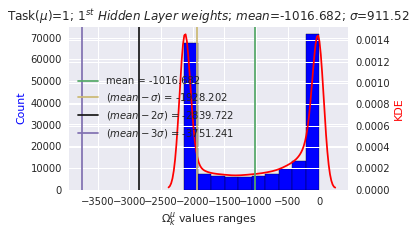

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


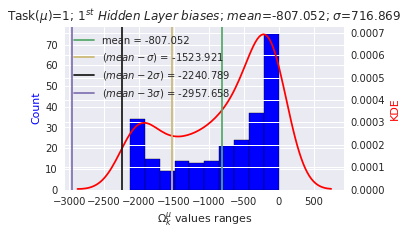

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


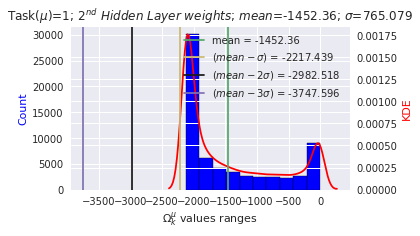

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


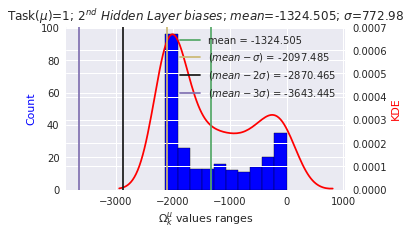

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


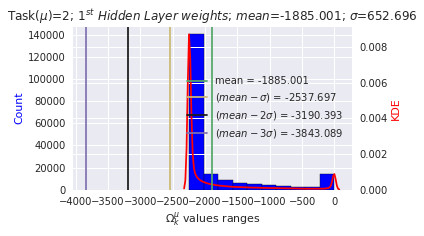

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


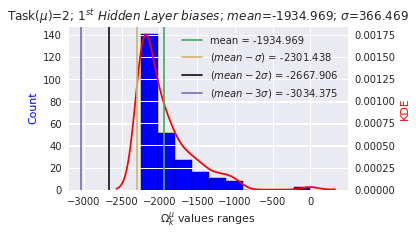

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


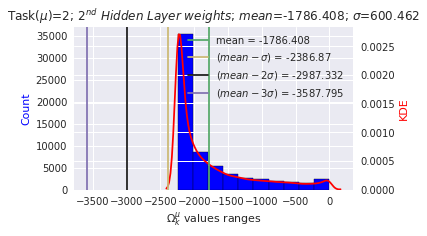

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


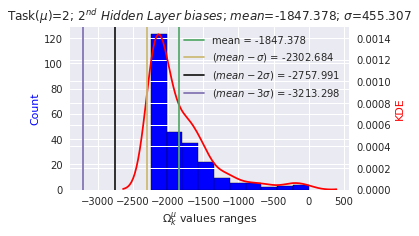

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


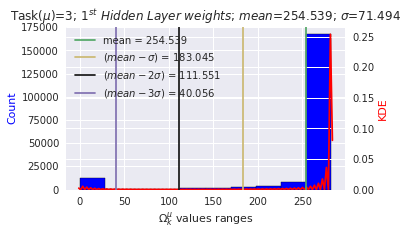

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


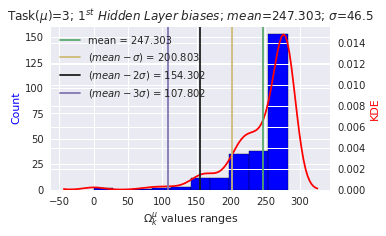

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


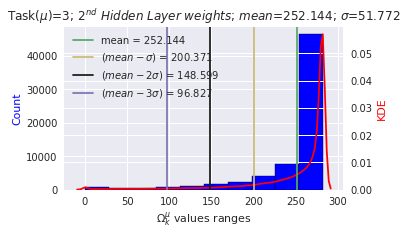

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


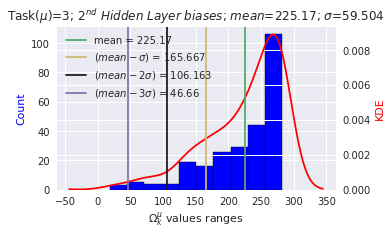

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


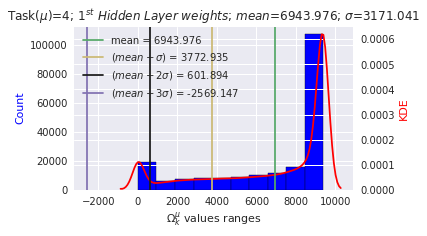

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


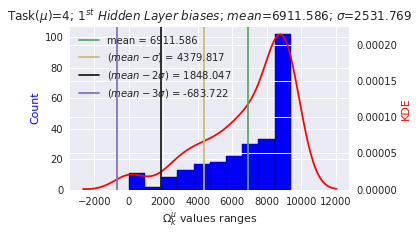

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


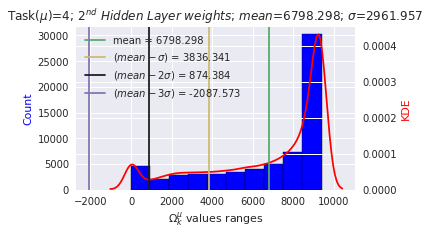

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


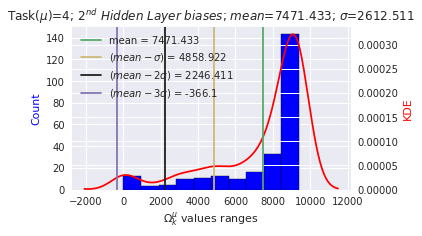

In [119]:
# histogram plot
from numpy.random import seed
from numpy.random import randn
#%matplotlib inline
from matplotlib import pyplot
import itertools
import pdb
import seaborn as sns
sns.set(color_codes=True)

for i in imp_par.keys():
    flatweights = list(itertools.chain.from_iterable(imp_par[i]['iw1'].tolist()))
    pyplot.figure(figsize=(5,3))
    pyplot.hist(flatweights, color = 'blue', edgecolor = 'black', bins=10)
    ax = sns.distplot(flatweights, bins=10, kde=False, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_ylabel('Count')
    ax.set_xlabel('$\Omega^{\mu}_{k}$ values ranges')
    ax.yaxis.label.set_color('blue')
    second_ax = ax.twinx()
    sns.distplot(flatweights, ax=second_ax, kde=True, hist=False, color='red')
    second_ax.set_ylabel('KDE')
    second_ax.yaxis.label.set_color('red')
    pyplot.title('Task($\mu$)='+str(i)+'; $1^{st} \, \, Hidden \, \, Layer \, \, weights$;'+' $mean$='+str(round(np.mean(flatweights),3))+'; $\sigma$='+str(round(np.std(flatweights),3)))
    pyplot.axvline(x=round(np.mean(flatweights),3), label='mean = {}'.format(round(np.mean(flatweights),3)), c='g')
    pyplot.axvline(x=round(np.mean(flatweights),3) - round(np.std(flatweights),3), label='$(mean - \sigma)$ = {}'.format(round(np.mean(flatweights) - np.std(flatweights),3)), c='y')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 2*round(np.std(flatweights),3), label='$(mean - 2\sigma)$ = {}'.format(round(np.mean(flatweights) - 2 * np.std(flatweights),3)), c='k')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 3*round(np.std(flatweights),3), label='$(mean - 3\sigma)$ = {}'.format(round(np.mean(flatweights) - 3 * np.std(flatweights),3)), c='m')
    pyplot.legend()
    pyplot.savefig('ImportanceValue_w1_mnist'+str(i)+'.pdf',bbox_inches='tight')
    pylab.show()
    
    flatweights = imp_par[i]['ib1'].tolist()
    pyplot.figure(figsize=(5,3))
    pyplot.hist(flatweights, color = 'blue', edgecolor = 'black', bins=10)
    ax = sns.distplot(flatweights, bins=10, kde=False, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_ylabel('Count')
    ax.set_xlabel('$\Omega^{\mu}_{k}$ values ranges')
    ax.yaxis.label.set_color('blue')
    second_ax = ax.twinx()
    sns.distplot(flatweights, ax=second_ax, kde=True, hist=False, color='red')
    second_ax.set_ylabel('KDE')
    second_ax.yaxis.label.set_color('red')
    pyplot.title('Task($\mu$)='+str(i)+'; $1^{st} \, \, Hidden \, \, Layer \, \, biases$;'+' $mean$='+str(round(np.mean(flatweights),3))+'; $\sigma$='+str(round(np.std(flatweights),3)))
    pyplot.axvline(x=round(np.mean(flatweights),3), label='mean = {}'.format(round(np.mean(flatweights),3)), c='g')
    pyplot.axvline(x=round(np.mean(flatweights),3) - round(np.std(flatweights),3), label='$(mean - \sigma)$ = {}'.format(round(np.mean(flatweights) - np.std(flatweights),3)), c='y')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 2*round(np.std(flatweights),3), label='$(mean - 2\sigma)$ = {}'.format(round(np.mean(flatweights) - 2 * np.std(flatweights),3)), c='k')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 3*round(np.std(flatweights),3), label='$(mean - 3\sigma)$ = {}'.format(round(np.mean(flatweights) - 3 * np.std(flatweights),3)), c='m')
    pyplot.legend()
    pyplot.savefig('ImportanceValue_b1_mnist'+str(i)+'.pdf',bbox_inches='tight')
    pylab.show()
    
    flatweights = list(itertools.chain.from_iterable(imp_par[i]['iw2'].tolist()))
    pyplot.figure(figsize=(5,3))
    pyplot.hist(flatweights, color = 'blue', edgecolor = 'black', bins=10)
    ax = sns.distplot(flatweights, bins=10, kde=False, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_ylabel('Count')
    ax.set_xlabel('$\Omega^{\mu}_{k}$ values ranges')
    ax.yaxis.label.set_color('blue')
    second_ax = ax.twinx()
    sns.distplot(flatweights, ax=second_ax, kde=True, hist=False, color='red')
    second_ax.set_ylabel('KDE')
    second_ax.yaxis.label.set_color('red')
    pyplot.title('Task($\mu$)='+str(i)+'; $2^{nd} \, \, Hidden \, \, Layer \, \, weights$;'+' $mean$='+str(round(np.mean(flatweights),3))+'; $\sigma$='+str(round(np.std(flatweights),3)))
    pyplot.axvline(x=round(np.mean(flatweights),3), label='mean = {}'.format(round(np.mean(flatweights),3)), c='g')
    pyplot.axvline(x=round(np.mean(flatweights),3) - round(np.std(flatweights),3), label='$(mean - \sigma)$ = {}'.format(round(np.mean(flatweights) - np.std(flatweights),3)), c='y')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 2*round(np.std(flatweights),3), label='$(mean - 2\sigma)$ = {}'.format(round(np.mean(flatweights) - 2 * np.std(flatweights),3)), c='k')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 3*round(np.std(flatweights),3), label='$(mean - 3\sigma)$ = {}'.format(round(np.mean(flatweights) - 3 * np.std(flatweights),3)), c='m')
    pyplot.legend()
    pyplot.savefig('ImportanceValue_w2_mnist'+str(i)+'.pdf',bbox_inches='tight')
    pylab.show()
    
    flatweights = imp_par[i]['ib2'].tolist()
    pyplot.figure(figsize=(5,3))
    pyplot.hist(flatweights, color = 'blue', edgecolor = 'black', bins=10)
    ax = sns.distplot(flatweights, bins=10, kde=False, color='blue', hist_kws={'edgecolor':'black'})
    ax.set_ylabel('Count')
    ax.set_xlabel('$\Omega^{\mu}_{k}$ values ranges')
    ax.yaxis.label.set_color('blue')
    second_ax = ax.twinx()
    sns.distplot(flatweights, ax=second_ax, kde=True, hist=False, color='red')
    second_ax.set_ylabel('KDE')
    second_ax.yaxis.label.set_color('red')
    pyplot.title('Task($\mu$)='+str(i)+'; $2^{nd} \, \, Hidden \, \, Layer \, \, biases$;'+' $mean$='+str(round(np.mean(flatweights),3))+'; $\sigma$='+str(round(np.std(flatweights),3)))
    pyplot.axvline(x=round(np.mean(flatweights),3), label='mean = {}'.format(round(np.mean(flatweights),3)), c='g')
    pyplot.axvline(x=round(np.mean(flatweights),3) - round(np.std(flatweights),3), label='$(mean - \sigma)$ = {}'.format(round(np.mean(flatweights) - np.std(flatweights),3)), c='y')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 2*round(np.std(flatweights),3), label='$(mean - 2\sigma)$ = {}'.format(round(np.mean(flatweights) - 2 * np.std(flatweights),3)), c='k')
    pyplot.axvline(x=round(np.mean(flatweights),3) - 3*round(np.std(flatweights),3), label='$(mean - 3\sigma)$ = {}'.format(round(np.mean(flatweights) - 3 * np.std(flatweights),3)), c='m')
    pyplot.legend()
    pyplot.savefig('ImportanceValue_b2_mnist'+str(i)+'.pdf',bbox_inches='tight')
    pylab.show()
    

In [120]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)

[1.0]


In [121]:
import h5py
print(model.summary())
model.save_weights('saved_weights.h5') #This file cannot be opend normaly to view the weghts. It can be loaded through load_model() or can be opend via hdf5 viewer

#Shape of the array containg model weights
a_list = model.get_weights()
for i in range(len(a_list)):
    print((np.array(a_list[i])).shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
None
(784, 256)
(256,)
(256, 256)
(256,)
(256, 10)
(10,)


In [122]:
data = utils.load_zipped_pickle(datafile_name)
print(cvals)
print(data)

[1.0]
{'std': {1.0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}, 'mean': {1.0: array([[0.99952719, 0.50538688, 0.52401281, 0.48237664, 0.49117499],
       [0.99952719, 0.99020568, 0.52401281, 0.48237664, 0.49117499],
       [1.        , 0.98579824, 0.99733191, 0.48237664, 0.49117499],
       [0.99952719, 0.99020568, 0.98345784, 0.99697885, 0.49117499],
       [0.99952719, 0.98090108, 0.98719317, 0.99748238, 0.93847705]])}}


In [123]:
for k in cvals:
    for i in range(n_tasks):
        for j in range(i):
            data['mean'][k][j][i] = 0
            data['std'][k][j][i] = 0
        
print(data)

{'std': {1.0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}, 'mean': {1.0: array([[0.99952719, 0.        , 0.        , 0.        , 0.        ],
       [0.99952719, 0.99020568, 0.        , 0.        , 0.        ],
       [1.        , 0.98579824, 0.99733191, 0.        , 0.        ],
       [0.99952719, 0.99020568, 0.98345784, 0.99697885, 0.        ],
       [0.99952719, 0.98090108, 0.98719317, 0.99748238, 0.93847705]])}}


In [15]:
#Reformating for the plots to show comparision between with/without prune grow
#Reformating for the plots to show comparision between with/without prune grow
#Experiment for prune/grow=0 is performed by commenting out two lines of code in run_fits method.
# They are :
#if age != 0:
#    imp_par[age] = model_prune(age, unimportant_threshold = n_tasks-age)
#Run the same process to collect mean and std of cross-validation accuracy to show the comparision plot.
data = {'mean': {0: array([[0.99952719, 0.        , 0.        , 0.        , 0.        ],
       [0.99952719, 0.99216454, 0.        , 0.        , 0.        ],
       [0.99952719, 0.98971596, 0.99786553, 0.        , 0.        ],
       [0.99952719, 0.99020568, 0.99679829, 0.99899295, 0.        ],
       [0.99952719, 0.99167483, 0.99786553, 0.99899295, 0.97226425]]), 1.0: array([[0.98952719, 0.        , 0.        , 0.        , 0.        ],
       [0.98952719, 0.97020568, 0.        , 0.        , 0.        ],
       [1.        , 0.97579824, 0.97733191, 0.        , 0.        ],
       [0.98952719, 0.98020568, 0.97345784, 0.9697885, 0.        ],
       [0.98952719, 0.98090108, 0.97719317, 0.96748238, 0.93847705]])}, 'std': {0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]), 1.0: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}}

In [16]:
import matplotlib.colors as colors
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-5, vmax=np.log(np.max(list(data['mean'].keys()))))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

(-5.0, 0.0)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


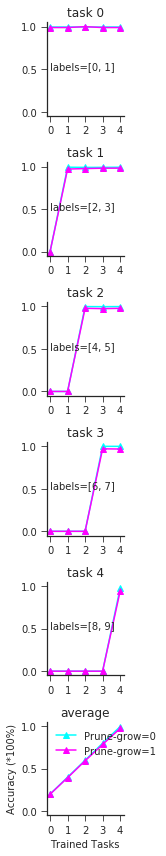

In [17]:
import pdb
figure(figsize=(2, 12))
axs = [subplot(n_tasks+1,1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(n_tasks+1,1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(data['mean'].keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    mean_vals = data['mean'][cval]
    std_vals = data['std'][cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        # axs[j].plot(evals[:, j], c=colorVal)
        axs[j].errorbar(range(n_tasks), mean_vals[:, j], yerr=std_vals[:, j]/np.sqrt(n_stats), c=colorVal, marker='^')
    label = "Prune-grow=%g"%cval
    average = mean_vals.mean(1)  #Taking the average of cross validation accuracies accross all tasks after learning each task
    axs[-1].plot(average, c=colorVal, label=label,marker='^')
    axs[-1].set_xticks(np.arange(0, n_tasks, step=1))
    axs[-1].set_xlabel('Trained Tasks')
    axs[-1].set_ylabel('Accuracy (*100%)')

plt_tasklabel = task_labels[:]
plt_tasklabel.append('')
for i, ax in enumerate(axs):
    ax.legend(loc='upper left')
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
    ax.text(0,0.5,('labels='+str(plt_tasklabel[i]))) if (i < len(task_labels)) else  ax.text(0,0.5,(plt_tasklabel[i]))

gcf().tight_layout()
sns.despine()
plt.savefig('Prune-Grow-MNIST.pdf',bbox_inches='tight')

In [18]:
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [19]:
print(mean_vals,average); print(type(mean_vals))

[[0.98952719 0.         0.         0.         0.        ]
 [0.98952719 0.97020568 0.         0.         0.        ]
 [1.         0.97579824 0.97733191 0.         0.        ]
 [0.98952719 0.98020568 0.97345784 0.9697885  0.        ]
 [0.98952719 0.98090108 0.97719317 0.96748238 0.93847705]] [0.19790544 0.39194657 0.59062603 0.78259584 0.97071617]
<class 'numpy.ndarray'>


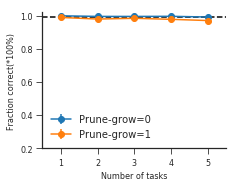

In [20]:
#Fractional Correctness = Average of cross validation accuracies of learned tasks only after training each task 
fig = plt.figure(figsize=(3.3,2.5))
ax = plt.subplot(111)

for cval in sorted_keys:
    mean_stuff = []
    std_stuff = []
    for i in range(len(data['mean'][cval])):
        mean_stuff.append(data['mean'][cval][i][:i+1].mean())
        std_stuff.append(np.sqrt((data['std'][cval][i][:i+1]**2).sum())/(n_stats*np.sqrt(n_stats)))
    # plot(range(1,n_tasks+1), mean_stuff, 'o-', label="c=%g"%cval)
    errorbar(range(1,n_tasks+1), mean_stuff, yerr=std_stuff, fmt='o-', label="Prune-grow=%g"%cval)
        
axhline(data['mean'][cval][0][0], linestyle='--', color='k')
xlabel('Number of tasks')
ylabel('Fraction correct(*100%)')
legend(loc='best')
xlim(0.5, n_tasks+0.5)
ylim(0.2, 1.02)
# grid('on')
# sns.despine()
simple_axis(ax)
plt.savefig('Prune-Grow-MNIST-fractionalcorrect.pdf',bbox_inches='tight')